# **ETL - CLIMA**

In [1]:
# [Configuración] Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")

## Variantes

### Lectura

In [ ]:

humedad = pd.read_csv('../ARCHIVOS/Entorno/humedad_diario.csv')
precipi = pd.read_csv('../ARCHIVOS/Entorno/precipitacion_diario.csv')
tempera = pd.read_csv('../ARCHIVOS/Entorno/temperaturas_diarias_media.csv')

In [3]:
df = pd.merge(humedad, precipi, on=['municipio', 'año', 'fecha'], how='inner')

# Unir el resultado anterior con temperatura
df = pd.merge(df, tempera, on=['municipio', 'año', 'fecha'], how='inner')

df = df[df['municipio'] != 'BARRANQUILLA']
df = df[df['año'] != 2017]
df = df.rename(columns={'latitud_x': 'latitud'})
df = df.rename(columns={'longitud_x': 'longitud'})
df['fecha'] = pd.to_datetime(df['fecha'])

df = df[['municipio', 'año', 'fecha', 'humedad', 'precipitacion', 'temp_min_C', 'temp_max_C', 'latitud', 'longitud']]
df.to_csv('../DATA/clima_diario.csv')

def play(df): 
    display(df.head())

play(df)

,municipio,año,fecha,humedad,precipitacion,temp_min_C,temp_max_C,latitud,latitud,longitud,longitud
8396,BARANOA,2018,2018-01-01,88.101349,6.68,23.320825,28.842126,10.793294,10.793294,-74.922196,-74.922196
8397,CAMPO DE LA CRUZ,2018,2018-01-01,86.504303,6.73,23.905847,30.760614,10.402621,10.402621,-74.878408,-74.878408
8398,CANDELARIA,2018,2018-01-01,87.891785,6.73,23.477167,30.556146,10.489020,10.489020,-74.877565,-74.877565
8399,GALAPA,2018,2018-01-01,87.767387,0.68,23.975977,29.207239,10.897721,10.897721,-74.887089,-74.887089
8400,JUAN DE ACOSTA,2018,2018-01-01,86.047791,2.10,23.653162,29.316431,10.823093,10.823093,-75.078424,-75.078424


### Imputación 

In [2]:
import pandas as pd
import numpy as np

# ------------------------------------------------------------
# 1️⃣ Cargar archivos
# ------------------------------------------------------------
df = pd.read_csv(r"C:\ETL_DENGUE\ARCHIVOS\Entorno\precipitacion_diario.csv", parse_dates=["fecha"])
centroides = pd.read_csv(r"C:\Dengue_caracterization\DATA_LAST\Datos adjuntos\centroides_municipios_atlantico.csv")

# Unir coordenadas
df = df.merge(centroides, on="municipio", how="left")

# ------------------------------------------------------------
# 2️⃣ Función para imputar valores negativos
# ------------------------------------------------------------
from math import radians, sin, cos, sqrt, atan2

def distancia_km(lat1, lon1, lat2, lon2):
    """Calcula distancia geodésica (Haversine) en km."""
    R = 6371.0  # Radio promedio de la Tierra en km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

def imputar_vecinos(df, variable, vecinos=3):
    """
    Imputa valores negativos usando el promedio de los N municipios más cercanos
    (solo en el mismo año y fecha).
    """
    df = df.copy()
    negativos = df[df[variable] < 0]

    print(f"🔍 Encontrados {len(negativos)} valores negativos para imputar...")

    for idx, row in negativos.iterrows():
        subset = df[
            (df["año"] == row["año"]) &
            (df["fecha"] == row["fecha"]) &
            (df[variable] >= 0)
        ].copy()

        # Calcular distancia a todos los demás municipios ese día
        subset["distancia"] = subset.apply(
            lambda r: distancia_km(row["latitud"], row["longitud"], r["latitud"], r["longitud"]),
            axis=1
        )

        # Seleccionar los 3 vecinos más cercanos
        vecinos_cercanos = subset.nsmallest(vecinos, "distancia")

        # Imputar con el promedio de esos vecinos
        valor_imputado = vecinos_cercanos[variable].mean()
        df.at[idx, variable] = valor_imputado

        print(f"🧩 Imputado {row['municipio']} ({row['fecha'].date()}): {valor_imputado:.2f}")

    return df

# ------------------------------------------------------------
# 3️⃣ Aplicar imputación
# ------------------------------------------------------------
df_imputado = imputar_vecinos(df, variable="precipitacion", vecinos=3)

# ------------------------------------------------------------
# 4️⃣ Guardar resultado final
# ------------------------------------------------------------
df_imputado.to_csv(r"C:\ETL_DENGUE\ARCHIVOS\Entorno\precipitacion_diario.csv", index=False, encoding="utf-8-sig")
print("✅ Archivo guardado")


🔍 Encontrados 5763 valores negativos para imputar...
🧩 Imputado LURUACO (2017-01-08): 0.29
🧩 Imputado PIOJÓ (2017-01-08): 0.29
🧩 Imputado REPELÓN (2017-01-08): 0.86
🧩 Imputado LURUACO (2017-01-09): 0.00
🧩 Imputado PIOJÓ (2017-01-09): 0.00
🧩 Imputado REPELÓN (2017-01-09): 0.06
🧩 Imputado LURUACO (2017-01-30): 0.13
🧩 Imputado PIOJÓ (2017-01-30): 0.13
🧩 Imputado REPELÓN (2017-01-30): 0.15
🧩 Imputado LURUACO (2017-02-09): 0.18
🧩 Imputado PIOJÓ (2017-02-09): 0.18
🧩 Imputado REPELÓN (2017-02-09): 0.33
🧩 Imputado LURUACO (2017-02-26): 0.14
🧩 Imputado PIOJÓ (2017-02-26): 0.14
🧩 Imputado REPELÓN (2017-02-26): 0.16
🧩 Imputado LURUACO (2017-03-07): 0.36
🧩 Imputado PIOJÓ (2017-03-07): 0.36
🧩 Imputado REPELÓN (2017-03-07): 0.73
🧩 Imputado LURUACO (2017-03-08): 1.24
🧩 Imputado PIOJÓ (2017-03-08): 1.27
🧩 Imputado REPELÓN (2017-03-08): 1.69
🧩 Imputado LURUACO (2017-03-09): 0.28
🧩 Imputado PIOJÓ (2017-03-09): 0.30
🧩 Imputado REPELÓN (2017-03-09): 0.37
🧩 Imputado LURUACO (2017-03-11): 3.08
🧩 Imputado PI

### Datos Completos

In [ ]:
import pandas as pd
from datetime import timedelta

# --- 1️⃣ Cargar tus CSV dialagoss ---
df_temp = pd.read_csv(r"C:\ETL_DENGUE\ARCHIVOS\Entorno\temperaturas_diarias_media.csv")       # columnas: municipio, año, fecha, temp_media_C
df_hum = pd.read_csv(r"C:\ETL_DENGUE\ARCHIVOS\Entorno\humedad_diario.csv")                            # columnas: municipio, año, fecha, humedad
df_prec = pd.read_csv(r"C:\ETL_DENGUE\ARCHIVOS\Entorno\precipitacion_diario.csv")                     # columnas: municipio, año, fecha, precipitacion

# --- 2️⃣ Convertir fechas ---
for df in [df_temp, df_hum, df_prec]:
    df["fecha"] = pd.to_datetime(df["fecha"])

# --- 3️⃣ Combinar todos los datos diarios ---
df = df_temp.merge(df_hum[["municipio", "año", "fecha", "humedad"]],
                   on=["municipio", "año", "fecha"], how="inner")

df = df.merge(df_prec[["municipio", "año", "fecha", "precipitacion"]],
              on=["municipio", "año", "fecha"], how="inner")

# --- 4️⃣ Calcular el número de periodo (cada 4 semanas = 28 días) ---
df["inicio_año"] = pd.to_datetime(df["año"].astype(str) + "-01-01")
df["dias_desde_inicio"] = (df["fecha"] - df["inicio_año"]).dt.days
df["periodo"] = (df["dias_desde_inicio"] // 28) + 1

# Semana (bloques de 7 días desde el 1 de enero)
df["semana"] = (df["dias_desde_inicio"] // 7) + 1

# --- 6️⃣ Agrupar por municipio, año, periodo y semana ---
df_periodos = df.groupby(["municipio", "año", "periodo", "semana"], as_index=False).agg({
    "temp_media_C": "mean",
    "humedad": "mean",
    "precipitacion": "mean"
})

# --- 7️⃣ Guardar resultado ---
df_periodos.rename(columns={
    "temp_media_C": "temp_media"
}, inplace=True)


df_periodos.to_csv(r"C:\ETL_DENGUE\ARCHIVOS\Entorno\clima_periodos_semana.csv", index=False)

print("✅ Archivo guardado")


✅ Archivo guardado


In [6]:
# Juntar los registros diarios del clima
# columnas: municipio, año, fecha, *variable climatica*

df_temp = pd.read_csv(r"C:\ETL_DENGUE\ARCHIVOS\Entorno\temperaturas_diarias_media.csv")       # columnas: municipio, año, fecha, temp_media_C
df_hum = pd.read_csv(r"C:\ETL_DENGUE\ARCHIVOS\Entorno\humedad_diario.csv")                            # columnas: municipio, año, fecha, humedad
df_prec = pd.read_csv(r"C:\ETL_DENGUE\ARCHIVOS\Entorno\precipitacion_diario.csv")   


df = df_temp.merge(df_hum[["municipio", "año", "fecha", "humedad"]],
                   on=["municipio", "año", "fecha"], how="inner")
df = df.merge(df_prec[["municipio", "año", "fecha", "precipitacion"]],
              on=["municipio", "año", "fecha"], how="inner")

# Eliminar columnas irrelevantes

df = df.drop(columns=['latitud', 'longitud', 'temp_max_C', 'temp_min_C'])

#Renombrar temp_media_C a temp_media

df = df.rename(columns={'temp_media_C': 'temp_media'})

df.to_csv(r"C:\ETL_DENGUE\DATA\clima_diario.csv", index=False)



## Fijas

In [2]:
mapa_atl = gpd.read_file("../ARCHIVOS/MAPAS_MUN/MGN_ADM_MPIO_GRAFICO.shp")
mapa_atl = mapa_atl[mapa_atl['dpto_cnmbr'] == 'ATLÁNTICO']
mapa_atl = mapa_atl.rename(columns={'mpio_cnmbr': 'municipio'})
mapa_atl = mapa_atl[mapa_atl['municipio'] != 'BARRANQUILLA']
mapa_atl.columns

Index(['dpto_ccdgo', 'mpio_ccdgo', 'mpio_cdpmp', 'dpto_cnmbr', 'municipio',
       'mpio_crslc', 'mpio_tipo', 'mpio_narea', 'mpio_nano', 'shape_Leng',
       'shape_Area', 'geometry'],
      dtype='object')

### Rios

In [4]:
CRS_PROYECTADO = "EPSG:3116"
rios = gpd.read_file(r"C:\Users\danie\DENGUE\MAPAS\MAPAS_RIOS\HydroRIVERS_v10_sa.shp")
rios = rios.to_crs(mapa_atl.crs)
rios_atl = gpd.clip(rios, mapa_atl)

mapa_atl = mapa_atl.to_crs(CRS_PROYECTADO)  
rios_atl = rios_atl.to_crs(CRS_PROYECTADO)

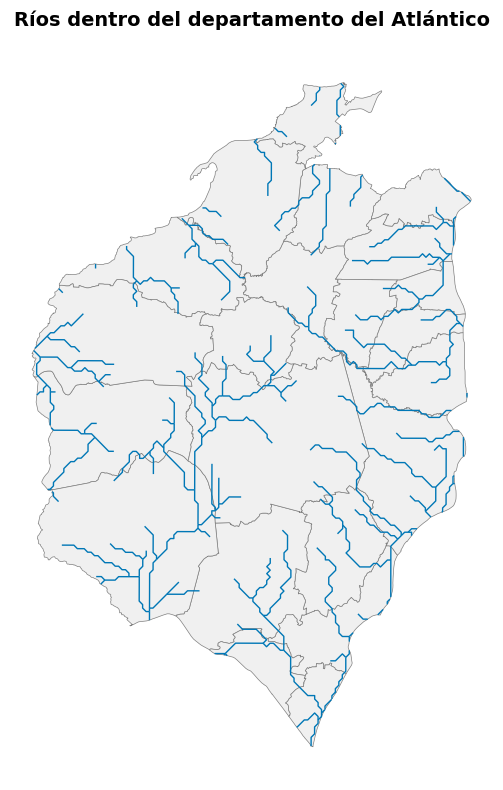

In [6]:
mapa_atl["centroide"] = mapa_atl.geometry.centroid
mapa_atl["dist_rio_mas_cercano_m"] = mapa_atl["centroide"].apply(
    lambda punto: rios_atl.distance(punto).min()
)
mapa_atl["dist_rio_mas_cercano_km"] = mapa_atl["dist_rio_mas_cercano_m"] / 1000

fig, ax = plt.subplots(figsize=(8, 8))
mapa_atl.plot(ax=ax, color="#f0f0f0", edgecolor="gray", linewidth=0.5)
rios_atl.plot(ax=ax, color="#0077b6", linewidth=1)
ax.set_title("Ríos dentro del departamento del Atlántico", fontsize=14, fontweight="bold")
ax.axis("off")
plt.tight_layout()
plt.show()

In [7]:
gdf_out = mapa_atl.drop(columns=["centroide"])
gdf_out.to_file('../DATA/MAPA_RIO/distancia_rio.shp')

### Lagos

In [3]:
CRS_PROYECTADO = "EPSG:3116"
lagos = gpd.read_file(r"C:\Users\danie\DENGUE\MAPAS\MAPAS_LAG\HydroLAKES_polys_v10.shp")
print("leidos")
lagos_c = lagos.to_crs(mapa_atl.crs)
lagos_atl = gpd.clip(lagos_c, mapa_atl)

mapa_atl = mapa_atl.to_crs(CRS_PROYECTADO)  
lagos_atl = lagos_atl.to_crs(CRS_PROYECTADO)

leidos


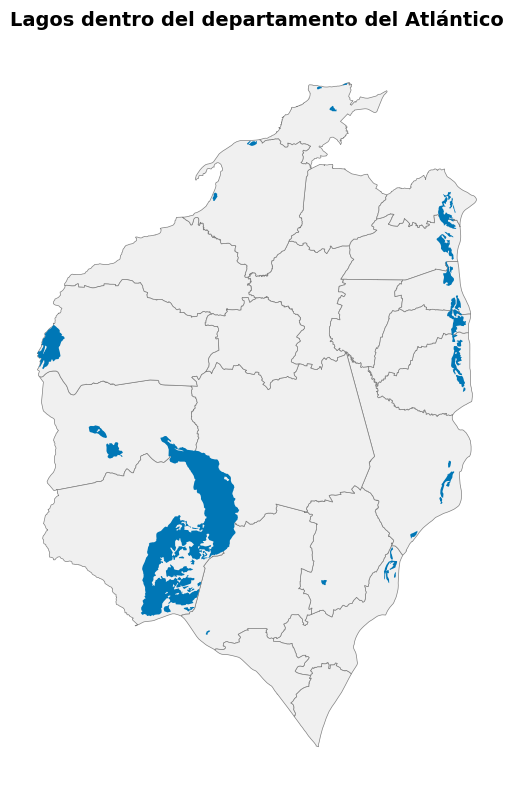

In [4]:
mapa_atl["centroide"] = mapa_atl.geometry.centroid
mapa_atl["dist_lago_mas_cercano_m"] = mapa_atl["centroide"].apply(
    lambda punto: lagos_atl.distance(punto).min()
)
mapa_atl["dist_lago_mas_cercano_km"] = mapa_atl["dist_lago_mas_cercano_m"] / 1000

fig, ax = plt.subplots(figsize=(8, 8))
mapa_atl.plot(ax=ax, color="#f0f0f0", edgecolor="gray", linewidth=0.5)
lagos_atl.plot(ax=ax, color="#0077b6", linewidth=1)
ax.set_title("Lagos dentro del departamento del Atlántico", fontsize=14, fontweight="bold")
ax.axis("off")
plt.tight_layout()
plt.show()

In [5]:
gdf_out = mapa_atl.drop(columns=["centroide"])
gdf_out.to_file('../DATA/MAPA_LAGO/distancia_lago.shp')